<!--BOOK_INFORMATION-->
<a href="https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv" target="_blank"><img align="left" src="data/cover.jpg" style="width: 76px; height: 100px; background: white; padding: 1px; border: 1px solid black; margin-right:10px;"></a>
*This notebook contains an excerpt from the book [Machine Learning for OpenCV](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv) by Michael Beyeler.
The code is released under the [MIT license](https://opensource.org/licenses/MIT),
and is available on [GitHub](https://github.com/mbeyeler/opencv-machine-learning).*

*Note that this excerpt contains only the raw code - the book is rich with additional explanations and illustrations.
If you find this content useful, please consider supporting the work by
[buying the book](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv)!*

<!--NAVIGATION-->
< [Implementing Our First Support Vector Machine](06.01-Implementing-Your-First-Support-Vector-Machine.ipynb) | [Contents](../README.md) | [Detecting Pedestrians with Support Vector Machines](06.03-Additional-SVM-Exercises.ipynb) >

# Detecting Pedestrians in the Wild

We briefly talked about the difference between detection and recognition. While recognition
is concerned with classifying objects (for example, as pedestrians, cars, bicycles, and so on),
detection is basically answering the question: is there a pedestrian present in this image?

The basic idea behind most detection algorithms is to split up an image into many small
patches, and then classify each image patch as either containing a pedestrian or not. This is
exactly what we are going to do in this section. In order to arrive at our own pedestrian
detection algorithm, we need to perform the following steps:
1. Build a database of images containing pedestrians. These will be our positive data samples.
2. Build a database of images not containing pedestrians. These will be our negative data samples.
3. Train an SVM on the dataset.
4. Apply the SVM to every possible patch of a test image in order to decide whether the overall image contains a pedestrian.

## Obtaining the dataset

For the purpose of this section, we will work with the MIT People dataset, which we are
free to use for non-commercial purposes. So make sure not to use this in your
groundbreaking autonomous start-up company before obtaining a corresponding software
license.

The dataset can be obtained from http://cbcl.mit.edu/software-datasets/PedestrianData.html. There you should find a DOWNLOAD button that leads you to a file called http://cbcl.mit.edu/projects/cbcl/software-datasets/pedestrians128x64.tar.gz.

However, if you followed our installation instructions from earlier and
checked out the code on GitHub, you already have the dataset and are
ready to go! The file can be found at
`notebooks/data/pedestrians128x64.tar.gz`. Since we are supposed to run this code from a Jupyter Notebook in the `notebooks/`
directory, the relative path to the data directory is simply `data/`:

In [1]:
datadir = "data/chapter6"
dataset = "pedestrians128x64"
datafile = "%s/%s.tar.gz" % (datadir, dataset)

The first thing to do is to unzip the file. We will extract all files into their own subdirectories
in `data/pedestrians128x64/`:

In [2]:
extractdir = "%s/%s" % (datadir, dataset)

We can do this either by hand (outside of Python) or with the following function:

In [3]:
def extract_tar(datafile, extractdir):
    try:
        import tarfile
    except ImportError:
        raise ImportError("You do not have tarfile installed. "
                          "Try unzipping the file outside of Python.")

    tar = tarfile.open(datafile)
    tar.extractall(path=extractdir)
    tar.close()
    print("%s successfully extracted to %s" % (datafile, extractdir))

Then we can call the function like this:

In [4]:
extract_tar(datafile, datadir)

data/chapter6/pedestrians128x64.tar.gz successfully extracted to data/chapter6


The dataset comes with a total of 924 color images of pedestrians, each scaled to 64 x 128
pixels and aligned so that the person's body is in the center of the image. Scaling and
aligning all data samples is an important step of the process, and we are glad that we don't
have to do it ourselves.

These images were taken in Boston and Cambridge in a variety of seasons and under
several different lighting conditions. We can visualize a few example images by reading the
image with OpenCV and passing an RGB version of the image to Matplotlib:

In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

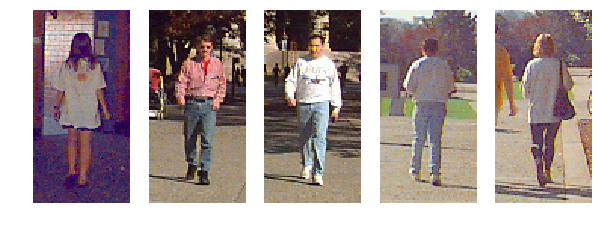

In [6]:
plt.figure(figsize=(10, 6))
for i in range(5):
    filename = "%s/per0010%d.ppm" % (extractdir, i)
    img = cv2.imread(filename)

    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

We can look at additional pictures, but it's pretty clear that there is no straightforward way
to describe pictures of people as easily as we did in the previous section for + and - data
points. Part of the problem is thus finding a good way to represent these images. Does this
ring a bell? It should! We're talking about feature engineering.

## Taking a glimpse at the histogram of oriented gradients (HOG)

The HOG might just provide the help we're looking for in order to get this project done.
HOG is a feature descriptor for images, much like the ones we discussed in [Chapter 4](),
*Representing Data and Engineering Features*. It has been successfully applied to many different
tasks in computer vision, but seems to work especially well for classifying people.

The essential idea behind HOG features is that the local shapes and appearance of objects
within an image can be described by the distribution of edge directions. The image is
divided into small connected regions, within which a histogram of gradient directions (or
**edge directions**) is compiled. Then, the descriptor is assembled by concatenating the
different histograms. Please refer to the book for an example illustration.

The HOG descriptor is fairly accessible in OpenCV by means of `cv2.HOGDescriptor`,
which takes a bunch of input arguments, such as the detection window size (minimum size
of the object to be detected, 48 x 96), the block size (how large each box is, 16 x 16), the cell
size (8 x 8), and the cell stride (how many pixels to move from one cell to the next, 8 x 8).
For each of these cells, the HOG descriptor then calculates a histogram of oriented gradients
using nine bins:

In [8]:
win_size = (48, 96)
block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
num_bins = 9
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

Although this function call looks fairly complicated, these are actually the only values for
which the HOG descriptor is implemented. The argument that matters the most is the
window size (`win_size`).

All that's left to do is call hog.compute on our data samples. For this, we build a dataset of
positive samples (`X_pos`) by randomly picking pedestrian images from our data directory.
In the following code snippet, we randomly select 400 pictures from the over 900 available,
and apply the HOG descriptor to them:

In [9]:
import numpy as np
import random
random.seed(42)
X_pos = []
for i in random.sample(range(900), 400):
    filename = "%s/per%05d.ppm" % (extractdir, i)
    img = cv2.imread(filename)
    if img is None:
        print('Could not find image %s' % filename)
        continue
    X_pos.append(hog.compute(img, (64, 64)))

Could not find image data/chapter6/pedestrians128x64/per00000.ppm


In [13]:
print(len(X_pos))
print(X_pos[0].shape)

399
(1980, 1)


We should also remember that OpenCV wants the feature matrix to contain 32-bit floating
point numbers, and the target labels to be 32-bit integers. We don't mind, since converting
to NumPy arrays will allow us to easily investigate the sizes of the matrices we created:

In [14]:
X_pos = np.array(X_pos, dtype=np.float32)
y_pos = np.ones(X_pos.shape[0], dtype=np.int32)
X_pos.shape, y_pos.shape

((399, 1980, 1), (399,))

It looks like we picked a total of 399 training samples, each of which have 1,980 feature
values (which are the HOG feature values).

## Generating negatives

The real challenge, however, is to come up with the perfect example of a non-pedestrian.
After all, it's easy to think of example images of pedestrians. But what is the opposite of a
pedestrian?

This is actually a common problem when trying to solve new machine learning problems.
Both research labs and companies spend a lot of time creating and annotating new datasets
that fit their specific purpose.

If you're stumped, let me give you a hint on how to approach this. A good first
approximation to finding the opposite of a pedestrian is to assemble a dataset of images that
look like the images of the positive class but do not contain pedestrians. These images could
contain anything like cars, bicycles, streets, houses, and maybe even forests, lakes, or
mountains.

A good place to start is the Urban and Natural Scene dataset by the Computational Visual
Cognition Lab at MIT. The complete dataset can be obtained from http://cvcl.mit.edu/database.htm, but don't bother. I have already assembled a good amount of images from
categories such as open country, inner cities, mountains, and forests. You can find them in
the `data/pedestrians_neg` directory:

In [15]:
negset = "pedestrians_neg"
negfile = "%s/%s.tar.gz" % (datadir, negset)
negdir = "%s/%s" % (datadir, negset)
extract_tar(negfile, datadir)

data/chapter6/pedestrians_neg.tar.gz successfully extracted to data/chapter6


All the images are in color, in `.jpeg` format, and are 256 x 256 pixels. However, in order to
use them as samples from a negative class that go together with our images of pedestrians
earlier, we need to make sure that all images have the same pixel size. Moreover, the things
depicted in the images should roughly be at the same scale. Thus, we want to loop through
all the images in the directory (via `os.listdir`) and cut out a 64 x 128 **region of interest
(ROI)**:

In [16]:
import os
hroi = 128
wroi = 64
X_neg = []
for negfile in os.listdir(negdir):
    filename = '%s/%s' % (negdir, negfile)
    img = cv2.imread(filename)
    img = cv2.resize(img, (512, 512))
    for j in range(5):
        rand_y = random.randint(0, img.shape[0] - hroi)
        rand_x = random.randint(0, img.shape[1] - wroi)
        roi = img[rand_y:rand_y + hroi, rand_x:rand_x + wroi, :]
        X_neg.append(hog.compute(roi, (64, 64)))

What did we almost forget? Exactly, we forgot to make sure that all feature values are 32-bit
floating point numbers. Also, the target label of these images should be -1, corresponding to
the negative class:

In [17]:
X_neg = np.array(X_neg, dtype=np.float32)
y_neg = -np.ones(X_neg.shape[0], dtype=np.int32)
X_neg.shape, y_neg.shape

((250, 1980, 1), (250,))

Then we can concatenate all positive (`X_pos`) and negative samples (`X_neg`) into a single
dataset `X`, which we split using the all too familiar `train_test_split` function from scikitlearn:

In [18]:
X = np.concatenate((X_pos, X_neg))
y = np.concatenate((y_pos, y_neg))
print(X.shape, y.shape)

(649, 1980, 1) (649,)


In [19]:
from sklearn import model_selection as ms
X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Implementing the support vector machine

We already know how to build an SVM in OpenCV, so there's nothing much to see here.
Planning ahead, we wrap the training procedure into a function, so that it's easier to repeat
the procedure in the future:

In [20]:
def train_svm(X_train, y_train):
    svm = cv2.ml.SVM_create()
    svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)
    return svm

The same can be done for the scoring function. Here we pass a feature matrix X and a label
vector y, but we do not specify whether we're talking about the training or the test set. In
fact, from the viewpoint of the function, it doesn't matter what set the data samples belong
to, as long as they have the right format:

In [21]:
def score_svm(svm, X, y):
    from sklearn import metrics
    _, y_pred = svm.predict(X)
    return metrics.accuracy_score(y, y_pred)

Then we can train and score the SVM with two short function calls:

In [22]:
svm = train_svm(X_train, y_train)

In [23]:
score_svm(svm, X_train, y_train)

1.0

In [24]:
score_svm(svm, X_test, y_test)

0.6461538461538462

Thanks to the HOG feature descriptor, we make no mistake on the training set. However,
our generalization performance is quite abysmal (64.6 percent), as it is much less than the
training performance (100 percent). This is an indication that the model is **overfitting** the
data. The fact that it is performing way better on the training set than the test set means that
the model has resorted to memorizing the training samples, rather than trying to abstract it
into a meaningful decision rule.

What can we do to improve the model performance?

## Bootstrapping the model

An interesting way to improve the performance of our model is to use **bootstrapping**. This
idea was actually applied in one of the first papers on using SVMs in combination with
HOG features for pedestrian detection. So let's pay a little tribute to the pioneers and try to
understand what they did.

Their idea was quite simple. After training the SVM on the training set, they scored the
model and found that the model produced some false positives. Remember that false
positive means that the model predicted a positive (+) for a sample that was really a
negative (-). In our context, this would mean the SVM falsely believed an image to contain a
pedestrian. If this happens for a particular image in the dataset, this example is clearly
troublesome. Hence, we should add it to the training set and retrain the SVM with the
additional troublemaker, so that the algorithm can learn to classify that one correctly. This
procedure can be repeated until the SVM gives satisfactory performance.

We will talk about bootstrapping in more detail in [Chapter 11](11.00-Selecting-the-Right-Model-with-Hyper-Parameter-Tuning.ipynb), *Selecting the Right Model with Hyperparameter Tuning*.

Let's do the same. We will repeat the training procedure a maximum of three times. After
each iteration, we identify the false positives in the test set and add them to the training set
for the next iteration:

In [25]:
score_train = []
score_test = []
for j in range(3):
    svm = train_svm(X_train, y_train)
    score_train.append(score_svm(svm, X_train, y_train))
    score_test.append(score_svm(svm, X_test, y_test))
    
    _, y_pred = svm.predict(X_test)
    false_pos = np.logical_and((y_test.ravel() == -1), (y_pred.ravel() == 1))
    if not np.any(false_pos):
        print('done')
        break
    X_train = np.concatenate((X_train, X_test[false_pos, :]), axis=0)
    y_train = np.concatenate((y_train, y_test[false_pos]), axis=0)

done


This allows us to improve the model over time:

In [26]:
score_train

[1.0, 1.0]

In [27]:
score_test

[0.6461538461538462, 1.0]

Here, we achieved 64.6 percent accuracy in the first round, but were able to get that up to a
perfect 100 percent in the second round.

## Detecting pedestrians in a larger image

What's left to do is to connect the SVM classification procedure with the process of
detection. The way to do this is to repeat our classification for every possible patch in the
image. This is similar to what we did earlier when we visualized decision boundaries; we
created a fine grid and classified every point on that grid. The same idea applies here. We
divide the image into patches and classify every patch as either containing a pedestrian or
not.

Therefore, if we want to do this, we have to loop over all possible patches in an image, each
time shifting our region of interest by a small number of `stride` pixels:

In [28]:
img_test = cv2.imread('data/chapter6/pedestrian_test.jpg')

In [29]:
stride = 16
found = []
for ystart in np.arange(0, img_test.shape[0], stride):
    for xstart in np.arange(0, img_test.shape[1], stride):
        if ystart + hroi > img_test.shape[0]:
            continue
        if xstart + wroi > img_test.shape[1]:
            continue
        roi = img_test[ystart:ystart + hroi, xstart:xstart + wroi, :]
        feat = np.array([hog.compute(roi, (64, 64))])
        _, ypred = svm.predict(feat)
        if np.allclose(ypred, 1):
            found.append((ystart, xstart, hroi, wroi))

Because pedestrians could appear not just at various locations but also in various sizes, we
would have to rescale the image and repeat the whole process. Thankfully, OpenCV has a
convenience function for this **multi-scale detection task** in the form of the
`detectMultiScale` function. This is a bit of a hack, but we can pass all SVM parameters to
the `hog` object:

In [30]:
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

In [31]:
rho, _, _ = svm.getDecisionFunction(0)
sv = svm.getSupportVectors()
hog.setSVMDetector(np.append(sv[0, :].ravel(), rho))

In practice, when people are faced with a standard task such as pedestrian detection, they
often rely on precanned SVM classifiers that are built into OpenCV. This is the method that
I hinted at in the very beginning of this chapter. By loading either
`cv2.HOGDescriptor_getDaimlerPeopleDetector()` or
`cv2.HOGDescriptor_getDefaultPeopleDetector()`, we can get started with only a
few lines of code:

In [32]:
hogdef = cv2.HOGDescriptor()

In [33]:
hogdef.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

In [35]:
found, _ = hogdef.detectMultiScale(img_test)
print(found)

[[ 13 111  71 142]
 [ 62 111  69 138]
 [141  95  65 130]]


Then we can mark the detected pedestrians in the image by looping over the bounding
boxes in found:

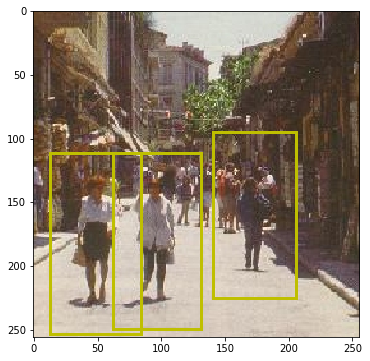

In [36]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
from matplotlib import patches
for f in found:
    ax.add_patch(patches.Rectangle((f[0], f[1]), f[2], f[3], color='y', linewidth=3, fill=False))
plt.savefig('detected.png')

<!--NAVIGATION-->
< [Implementing Our First Support Vector Machine](06.01-Implementing-Your-First-Support-Vector-Machine.ipynb) | [Contents](../README.md) | [Detecting Pedestrians with Support Vector Machines](06.03-Additional-SVM-Exercises.ipynb) >